In [1]:

import os


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda1,floatX=float32, nvcc.flags=-D_FORCE_INLINES"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu1,floatX=float32"
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu1,floatX=float32"
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.layers import Input,  ZeroPadding2D,concatenate
from keras.layers.merge import concatenate
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers.advanced_activations import ELU
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from keras.layers.noise import AlphaDropout
from keras.models import model_from_json
import json
from inner_func import get_hubs_last_conv_name, get_filtered_idx, get_last_conv_layer_name, recursive_find_root_conv
import numpy as np
np.random.seed(1337)
from keras.layers import  regularizers

import psutil
import timeit
import gc

from os import listdir
import glob
import time
import cv2
import warnings
warnings.filterwarnings("ignore")
from custom_layers.scale_layers2 import Scale

img_rows, img_cols=224,224
img_channels = 3
nb_classes = 185
root_total = '/media/data/TOO/plantsdiseases/images/field'
disease_CLASSES = listdir(root_total)

#disease_CLASSES = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37']


Using TensorFlow backend.


In [ ]:
def get_mem_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info()

In [2]:
from keras.layers import Flatten
def densenet161_model( img_rows, img_cols, color_type=1, nb_dense_block=4, growth_rate=48, nb_filter=96, reduction=0.5, dropout_rate=0.0, weight_decay=1e-4, num_classes=None):
    '''
    DenseNet 121 Model for Keras

    Model Schema is based on 
    https://github.com/flyyufelix/DenseNet-Keras

    ImageNet Pretrained Weights 
    Theano: https://drive.google.com/open?id=0Byy2AcGyEVxfMlRYb3YzV210VzQ
    TensorFlow: https://drive.google.com/open?id=0Byy2AcGyEVxfSTA4SHJVOHNuTXc

    # Arguments
        nb_dense_block: number of dense blocks to add to end
        growth_rate: number of filters to add per dense block
        nb_filter: initial number of filters
        reduction: reduction factor of transition blocks.
        dropout_rate: dropout rate
        weight_decay: weight decay factor
        classes: optional number of classes to classify images
        weights_path: path to pre-trained weights
    # Returns
        A Keras model instance.
    '''
    eps = 1.1e-5

    # compute compression factor
    compression = 1.0 - reduction

    # Handle Dimension Ordering for different backends
    global concat_axis
    if K.image_data_format() == 'channels_last':
      concat_axis = 3
      img_input = Input(shape=(img_rows, img_cols, color_type), name='data')
    else:
      concat_axis = 1
      img_input = Input(shape=(color_type, img_rows, img_cols), name='data')

    # From architecture for ImageNet (Table 1 in the paper)
    nb_filter = 96
    nb_layers = [6,12,36,24] # For DenseNet-121

    # Initial convolution
    x = ZeroPadding2D((3, 3), name='conv1_zeropadding')(img_input)
    x = Conv2D(nb_filter, 7, 7, subsample=(2, 2), name='conv1', use_bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv1_bn')(x)
    #x = Scale(axis=concat_axis, name='conv1_scale')(x)
    x = Activation('relu', name='relu1')(x)
    x = ZeroPadding2D((1, 1), name='pool1_zeropadding')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)

    # Add dense blocks
    for block_idx in range(nb_dense_block - 1):
        stage = block_idx+2
        x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

        # Add transition_block
        x = transition_block(x, stage, nb_filter, compression=compression, dropout_rate=dropout_rate, weight_decay=weight_decay)
        nb_filter = int(nb_filter * compression)

    final_stage = stage + 1
    x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

    x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv'+str(final_stage)+'_blk_bn')(x)
    #x = Scale(axis=concat_axis, name='conv'+str(final_stage)+'_blk_scale')(x)
    #x = Activation('relu', name='relu'+str(final_stage)+'_blk')(x)
    x = Activation('relu', name='relu'+str(final_stage)+'_blk')(x)
    x_fc = GlobalAveragePooling2D(name='pool'+str(final_stage))(x)
    x_fc = Dense(1000, name='fc6')(x_fc)
    
    x_fc = Activation('softmax', name='prob')(x_fc)
    #x_fc = Activation('selu', name='prob_selu')(x_fc)
    
    model = Model(img_input, x_fc, name='densenet')

    if K.image_data_format() == 'channels_first':
      # Use pre-trained weights for Theano backend
      weights_path = 'densenet161_weights_th.h5'
    else:
      # Use pre-trained weights for Tensorflow backend
      weights_path = 'densenet161_weights_tf.h5'

    model.load_weights(weights_path, by_name=True)

    # Truncate and replace softmax layer for transfer learning
    # Cannot use model.layers.pop() since model is not of Sequential() type
    # The method below works since pre-trained weights are stored in layers but not in the model
    x_newfc = GlobalAveragePooling2D(name='pool'+str(final_stage))(x)
    #x_newfc = Dense(num_classes, name='fc6')(x_newfc)
    x_newfc = Dense(num_classes, name='fc6')(x_newfc)
   
    x_newfc = Activation('softmax', name='prob')(x_newfc)

    model = Model(img_input, x_newfc)

    # Learning rate is changed to 0.001
    #sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    #model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [3]:
def conv_block(x, stage, branch, nb_filter, dropout_rate=None, weight_decay=1e-4):
    '''Apply BatchNorm, Relu, bottleneck 1x1 Conv2D, 3x3 Conv2D, and option dropout
        # Arguments
            x: input tensor 
            stage: index for dense block
            branch: layer index within each dense block
            nb_filter: number of filters
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''
    eps = 1.1e-5
    conv_name_base = 'conv' + str(stage) + '_' + str(branch)
    relu_name_base = 'selu' + str(stage) + '_' + str(branch)

    # 1x1 Convolution (Bottleneck layer)
    inter_channel = nb_filter * 4  
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x1_bn')(x)
    #x = Scale(axis=concat_axis, name=conv_name_base+'_x1_scale')(x)
    x = Activation('relu', name=relu_name_base+'_x1')(x)
    #x =ELU(x,alpha=1.0)
    x = Conv2D(inter_channel, 1, 1, name=conv_name_base+'_x1', use_bias=False)(x)
    #x = Conv2D(inter_channel, 1, 1, name="conv2_1_x1", use_bias=False)(x)
    if dropout_rate:
        x = AlphaDropout(dropout_rate)(x)

    # 3x3 Convolution
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x2_bn')(x)
    #x = Scale(axis=concat_axis, name=conv_name_base+'_x2_scale')(x)
    x = Activation('relu', name=relu_name_base+'_x2')(x)
    #x =ELU(x,alpha=1.0)(x)
    x = ZeroPadding2D((1, 1), name=conv_name_base+'_x2_zeropadding')(x)
    x = Conv2D(nb_filter, 3, 3, name=conv_name_base+'_x2', use_bias=False)(x)

    if dropout_rate:
        x = AlphaDropout(dropout_rate)(x)
        #x = Dropout(dropout_rate)(x)
    return x


In [4]:
def transition_block(x, stage, nb_filter, compression=1.0, dropout_rate=None, weight_decay=1E-4):
    ''' Apply BatchNorm, 1x1 Convolution, averagePooling, optional compression, dropout 
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_filter: number of filters
            compression: calculated as 1 - reduction. Reduces the number of feature maps in the transition block.
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''

    eps = 1.1e-5
    conv_name_base = 'conv' + str(stage) + '_blk'
    relu_name_base = 'relu' + str(stage) + '_blk'
    pool_name_base = 'pool' + str(stage) 

    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_bn')(x)
    #x = Scale(axis=concat_axis, name=conv_name_base+'_scale')(x)
    x = Activation('relu', name=relu_name_base)(x)
    #x =ELU(x,alpha=1.0)(x)
    x = Conv2D(int(nb_filter * compression), 1, 1, name=conv_name_base, use_bias=False)(x)

    if dropout_rate:
        x = AlphaDropout(dropout_rate)(x)

    x = AveragePooling2D((2, 2), strides=(2, 2), name=pool_name_base)(x)

    return x



In [5]:
def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, weight_decay=1e-4, grow_nb_filters=True):
    ''' Build a dense_block where the output of each conv_block is fed to subsequent ones
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_layers: the number of layers of conv_block to append to the model.
            nb_filter: number of filters
            growth_rate: growth rate
            dropout_rate: dropout rate
            weight_decay: weight decay factor
            grow_nb_filters: flag to decide to allow number of filters to grow
    '''

    eps = 1.1e-5
    concat_feat = x

    for i in range(nb_layers):
        branch = i+1
        x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate, weight_decay)
        concat_feat = concatenate([concat_feat, x], axis=concat_axis, name='concat_'+str(stage)+'_'+str(branch))

        if grow_nb_filters:
            nb_filter += growth_rate

    return concat_feat, nb_filter


In [ ]:
def preprocess_input(x, data_format=None):
    """Preprocesses a tensor encoding a batch of images.
    # Arguments
        x: input Numpy tensor, 4D.
        data_format: data format of the image tensor.
    # Returns
        Preprocessed tensor.
    """
    if data_format is None:
        data_format = K.image_data_format()
    assert data_format in {'channels_last', 'channels_first'}

    if data_format == 'channels_first':
        if x.ndim == 3:
            # 'RGB'->'BGR'
            x = x[::-1, ...]
            # Zero-center by mean pixel
            x[0, :, :] -= 103.939
            x[1, :, :] -= 116.779
            x[2, :, :] -= 123.68
        else:
            x = x[:, ::-1, ...]
            x[:, 0, :, :] -= 103.939
            x[:, 1, :, :] -= 116.779
            x[:, 2, :, :] -= 123.68
    else:
        # 'RGB'->'BGR'
        x = x[..., ::-1]
        # Zero-center by mean pixel
        x[..., 0] -= 103.939
        x[..., 1] -= 116.779
        x[..., 2] -= 123.68

    x *= 0.017 # scale values

    return x

In [7]:
def get_im_cv2(path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (img_rows, img_cols), interpolation=cv2.INTER_LINEAR)
    return resized

def load_train():
    X_train = []
    X_train_id = []
    y_train = []
    start_time = time.time()

    print('Read train images')
    #folders = ['Common_rust','healthy','Leaf_blight','leaf_spot']
    for fld in disease_CLASSES:
        index = disease_CLASSES.index(fld)
        #print('Load folder {} (Index: {})'.format(fld, index))
        
        path = os.path.join('..', 'plantsdiseases','images', 'train', fld,'*')
        files = glob.glob(path)
        #print path
        #print files
        for fl in files:
            #print str(fl)
            flbase = os.path.basename(fl)
            img = get_im_cv2(fl)
            X_train.append(img)
            X_train_id.append(flbase)
            y_train.append(index)

    print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return X_train, y_train, X_train_id

train_data, train_target, train_id = load_train()

train_data=np.array(train_data, dtype=np.uint8)

train_data=(train_data.astype('float32'))/255

#mean and std deviation of training set
data_mean=np.mean(train_data,axis=0)
data_stddev=np.std(train_data,axis=0)

#normalize data according to mean and sdev of training set
train_data=(train_data-data_mean)/data_stddev

#Reshaping the dataset
train_data=train_data.transpose((0, 1, 2, 3))

train_target = np_utils.to_categorical(train_target, nb_classes)

print('train_data shape:', train_data.shape)
print(train_data.shape[0], 'train samples')




Read train images
Read train data time: 44.05 seconds
train_data shape: (6858, 224, 224, 3)
6858 train samples


In [8]:
model = densenet161_model( img_rows=img_rows, img_cols=img_cols, color_type=img_channels,num_classes=nb_classes)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [9]:
import tensorflow as tf
import keras.backend as K


def get_flops(model):
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()

    # We use the Keras session graph in the call to the profiler.
    flops = tf.profiler.profile(graph=K.get_session().graph,
                                run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops  # Prints the "flops" of the model.


# .... Define your model here ....
print(get_flops(model))

59716674


In [10]:
from sklearn.model_selection import train_test_split
x_train,x_val, Y_train,Y_val=train_test_split(train_data,train_target,test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
import keras.backend as K


def get_flops(model):
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()

    # We use the Keras session graph in the call to the profiler.
    flops = tf.profiler.profile(graph=K.get_session().graph,
                                run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops  # Prints the "flops" of the model.


# .... Define your model here ....
print(get_flops(model))

In [12]:


model.summary()

sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy','top_k_categorical_accuracy'])
hist=model.fit(x_train, Y_train,
              batch_size=20,
              epochs=50,
              shuffle=True,
              verbose=1,
              validation_data=(x_val,Y_val),
              )



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
data (InputLayer)                (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1_zeropadding (ZeroPadding2D (None, 230, 230, 3)   0           data[0][0]                       
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 96)  14112       conv1_zeropadding[0][0]          
____________________________________________________________________________________________________
conv1_bn (BatchNormalization)    (None, 112, 112, 96)  384         conv1[0][0]                      
___________________________________________________________________________________________

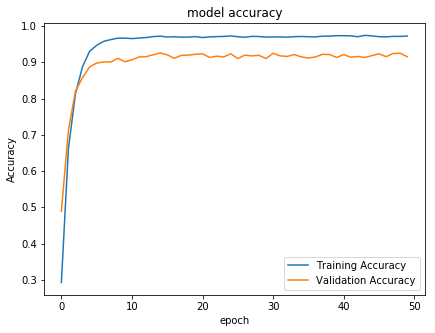

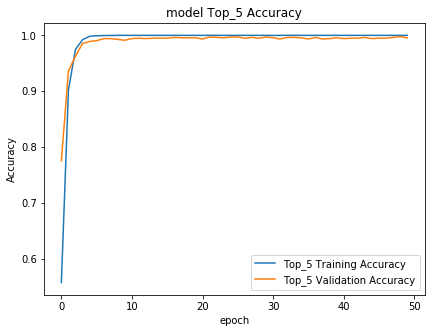

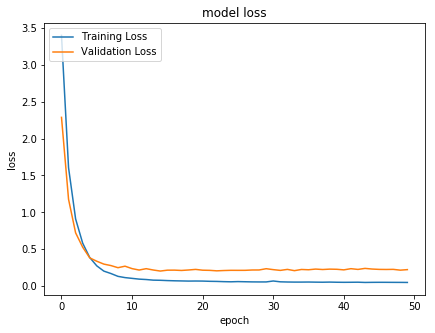

In [13]:
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['acc']); plt.plot(hist.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('Accuracy');
plt.xlabel('epoch'); plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='bottom right');
# summarize history for Top_5_accuracy
plt.show()
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['top_k_categorical_accuracy']); plt.plot(hist.history['val_top_k_categorical_accuracy']);
plt.title('model Top_5 Accuracy'); plt.ylabel('Accuracy');
plt.xlabel('epoch'); plt.legend(['Top_5 Training Accuracy', 'Top_5 Validation Accuracy'], loc='bottom right');
# summarize history for loss
plt.show()
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['Training Loss', 'Validation Loss'], loc='upper left');
plt.show()

In [14]:
import numpy as np
np.random.seed(1337)
import glob
import time
import cv2
def get_im_cv2(path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (img_rows, img_cols), interpolation=cv2.INTER_LINEAR)
    return resized
def load_test():
    X_test = []
    X_test_id = []
    y_test = []
    start_time = time.time()

    print('Read TEST images')
    #diseaseNames =  ['0']
  
    for fld in disease_CLASSES:
        index = disease_CLASSES.index(fld)
        #print('Load folder {} (Index: {})'.format(fld, index))
        path = os.path.join('..', 'plantsdiseases','images', 'test', fld, '*')
        files = glob.glob(path)
        #print (path)
        #print (files)
        for fl in files:
            #print str(fl)
            flbase = os.path.basename(fl)
            img = get_im_cv2(fl)
            X_test.append(img)
            X_test_id.append(flbase)
            y_test.append(index)

    print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return X_test, y_test, X_test_id
test_data, test_target,test_id = load_test()
X_test = np.array(test_data, dtype=np.uint8)
#mean and std deviation of training set
X_test = (X_test.astype('float32'))/255
test_mean=np.mean(X_test,axis=0)
test_stddev=np.std(X_test,axis=0)



#normalize data according to mean and sdev of training set

X_test=(X_test-test_mean)/test_stddev

X_test = X_test.transpose((0, 1, 2, 3))

# Normalizing the data

#X_test /= 255
y_test = np_utils.to_categorical(test_target, nb_classes)
print(X_test.shape[0], 'test samples')

Read TEST images
Read train data time: 5.52 seconds
861 test samples


In [15]:
score=model.evaluate(X_test,y_test,verbose=1)

print('Test Loss:',score[0])
print('Test Accuracy:',score[1]*100)
print ('Top_5 Accuracy',score[2]*100)
print('Top_5 Error',100-score[2]*100)

861/861 [==============================] - 42s    
Test Loss: 0.24102189937015858
Test Accuracy: 92.33449467660104
Top_5 Accuracy 99.41927984478028
Top_5 Error 0.5807201552197228


In [16]:
from sklearn.metrics import log_loss,roc_auc_score,f1_score,roc_curve,auc
import tensorflow as tf
def auroc (y_true, y_pred):
    return tf.py_func(roc_auc_score,(y_true,y_pred), tf.double)
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_pos = tf.convert_to_tensor(y_pos, np.float32)
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

import tensorflow as tf
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [17]:
preds=model.predict(X_test, verbose=1)
yPred = np.argmax(preds, axis=1)
yTrue = test_target

#score = log_loss(y_valid, pred)

861/861 [==============================] - 46s    


In [18]:


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu1,floatX=float32"
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu1,floatX=float32"
from keras.optimizers import SGD,Adam
from keras.layers import Input, merge, ZeroPadding2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
#from batch_renorm import BatchRenormalization
from keras.models import Model
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from keras.layers.noise import AlphaDropout
from keras.models import model_from_json
import json

import numpy as np

np.random.seed(1337)
import glob
import time
import cv2
import warnings
warnings.filterwarnings("ignore")
#from custom_layers.scale_layer import Scale

disease_dir_test='../plantsdiseases/images/test'


def load_test():
    X_train = []
    X_train_id = []
    y_train = []
    start_time = time.time()

    print('Read train images')
    root_dir=listdir(disease_dir_test)
    for fld in root_dir:
        index = root_dir.index(fld)
        print('Load folder {} (Index: {})'.format(fld, index))
        
        path = os.path.join('..', 'plantsdiseases', 'images', 'test', fld,'*')
        files = glob.glob(path)
        #print path
        #print (files)
        for fl in files:
            #print str(fl)
            flbase = os.path.basename(fl)
            img = get_im_cv2(fl)
            X_train.append(img)
            X_train_id.append(flbase)
            y_train.append(index)

    print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return X_train, y_train, X_train_id




#validation data processing
x_test, y_test,valid_id = load_test()
test_data=np.array(x_test, dtype=np.uint8)

test_data=(test_data.astype('float32'))/255
#mean and std deviation of training set

test_mean=np.mean(test_data,axis=0)
test_stddev=np.std(test_data,axis=0)
#normalize data according to mean and sdev of training set
test_data=(test_data-test_mean)/test_stddev

#Reshaping the dataset

test_data= test_data.transpose((0, 1, 2, 3))

test_target1 = np_utils.to_categorical(y_test, nb_classes)
print('train_data shape:', test_data.shape)
print(test_data.shape[0], 'validation samples')

Read train images
Load folder magnolia_stellata (Index: 0)
Load folder liriodendron_tulipifera (Index: 1)
Load folder picea_pungens (Index: 2)
Load folder amelanchier_canadensis (Index: 3)
Load folder pseudolarix_amabilis (Index: 4)
Load folder carya_glabra (Index: 5)
Load folder pinus_strobus (Index: 6)
Load folder taxodium_distichum (Index: 7)
Load folder prunus_sargentii (Index: 8)
Load folder ailanthus_altissima (Index: 9)
Load folder styrax_obassia (Index: 10)
Load folder morus_alba (Index: 11)
Load folder pinus_parviflora (Index: 12)
Load folder salix_nigra (Index: 13)
Load folder quercus_rubra (Index: 14)
Load folder pinus_peucea (Index: 15)
Load folder tilia_cordata (Index: 16)
Load folder fagus_grandifolia (Index: 17)
Load folder evodia_daniellii (Index: 18)
Load folder pinus_wallichiana (Index: 19)
Load folder amelanchier_laevis (Index: 20)
Load folder acer_griseum (Index: 21)
Load folder pinus_flexilis (Index: 22)
Load folder prunus_pensylvanica (Index: 23)
Load folder prunu

In [19]:
yPreds = new_model.predict(test_data, verbose=1)
yPred = np.argmax(yPreds, axis=1)
yTrue = test_target1

NameError: name 'new_model' is not defined

In [ ]:
score=new_model.evaluate(test_data,test_target1,verbose=1)
print('Test Loss:',score[0])
print('Test Accuracy:',score[1]*100)
print ('Top_5 Accuracy',score[2]*100)
print('Top_5 Error',100-score[2]*100)

In [ ]:


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu1,floatX=float32"
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu1,floatX=float32"
from keras.optimizers import SGD,Adam
from keras.layers import Input, merge, ZeroPadding2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
#from batch_renorm import BatchRenormalization
from keras.models import Model
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from keras.layers.noise import AlphaDropout
from keras.models import model_from_json
import json

import numpy as np

np.random.seed(1337)
import glob
import time
import cv2
import warnings
warnings.filterwarnings("ignore")
#from custom_layers.scale_layer import Scale

disease_dir_test='../plantsdiseases/images/test'


def load_test():
    X_train = []
    X_train_id = []
    y_train = []
    start_time = time.time()

    print('Read train images')
    root_dir=listdir(disease_dir_test)
    for fld in root_dir:
        index = root_dir.index(fld)
        print('Load folder {} (Index: {})'.format(fld, index))
        
        path = os.path.join('..', 'plantsdiseases','images', 'test', fld,'*')
        files = glob.glob(path)
        #print path
        #print (files)
        for fl in files:
            #print str(fl)
            flbase = os.path.basename(fl)
            img = get_im_cv2(fl)
            X_train.append(img)
            X_train_id.append(flbase)
            y_train.append(fld)

    print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return X_train, y_train, X_train_id




#validation data processing
x_test, y_test,valid_id = load_test()
test_data=np.array(x_test, dtype=np.uint8)

test_data=(test_data.astype('float32'))/255
#mean and std deviation of training set

test_mean=np.mean(test_data,axis=0)
test_stddev=np.std(test_data,axis=0)
#normalize data according to mean and sdev of training set
test_data=(test_data-test_mean)/test_stddev

#Reshaping the dataset

test_data= test_data.transpose((0, 1, 2, 3))

#test_target1 = np_utils.to_categorical(y_test, nb_classes)
print('train_data shape:', test_data.shape)
print(test_data.shape[0], 'validation samples')

In [ ]:
from math import sqrt

import matplotlib.pyplot as plt
from keras import backend as K
root_dir=listdir(disease_dir_test)

    
Num_fruits = 20
#model_fn = 'leafnet.h5'

# Function by gcalmettes from http://stackoverflow.com/questions/11159436/multiple-figures-in-a-single-window
def plot_figures(figures, nrows = 1, ncols=1, titles=False):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in enumerate(sorted(figures.keys(), key=lambda s: int(s[3:]))):
        axeslist.ravel()[ind].imshow(figures[title])
        if titles:
            axeslist.ravel()[ind].set_title(title)

    for ind in range(nrows*ncols):
        axeslist.ravel()[ind].set_axis_off()

    if titles:
        plt.tight_layout()
    plt.show()


def get_dim(num):
    """
    Simple function to get the dimensions of a square-ish shape for plotting
    num images
    """

    s = sqrt(num)
    if round(s) < s:
        return (int(s), int(s)+1)
    else:
        return (int(s)+1, int(s)+1)

# Load the best model
#model = load_model(model_fn)

# Get the convolutional layers
#conv_layers = [layer for layer in new_model.layers if isinstance(layer, MaxPooling2D)]

# Pick random images to visualize
imgs_to_visualize = np.random.choice(np.arange(0, len(test_data)), Num_fruits)

# Use a keras function to extract the conv layer data
#convout_func = K.function([new_model.layers[0].input, K.learning_phase()], [layer.output for layer in conv_layers])
#conv_imgs_filts = convout_func([test_data[imgs_to_visualize], 0])
# Also get the prediction so we know what we predicted
predictions = model.predict([test_data[imgs_to_visualize]])

#imshow = plt.imshow #alias
# Loop through each image disply relevant info
for img_count, img_to_visualize in enumerate(imgs_to_visualize):

    # Get top 3 predictions
    top3_ind = predictions[img_count].argsort()[-1:]
    top3_species = np.array(root_dir)[top3_ind]
    top3_preds = predictions[img_count][top3_ind]
    actual =y_test[img_to_visualize]
    if top3_species==actual:
        print("Predicted:%s: %s" % (top3_species, top3_preds))
        print("\nActual: %s" % actual)

    # Show the original image
        #plt.subplot(1,2,2)
        plt.axis('off')
        plt.title("Image used: #%d (digit=%d)" % (img_to_visualize, 10))
    # For Theano users comment the line below and
    #imshow(test_data[img_to_visualize][:, :, 0], cmap='gray')
    #plt.imshow(x_test[img_to_visualize]) # uncomment this
        plt.imshow(cv2.cvtColor(x_test[img_to_visualize],cv2.COLOR_BGR2RGB))
        plt.tight_layout()
        plt.show()
    
    #print("\nActual: %s" % actual)

    # Get the actual leaf species
    
    

    # Display the top 3 predictions and the actual species
    #print("Top 3 Predicitons:")
    #for i in range(2, -1, -1):
        
        #if top3_species[i]!=actual:
            #print("\t%s: %s" % (top3_species[i], top3_preds[i]))




In [ ]:
from math import sqrt

import matplotlib.pyplot as plt
from keras import backend as K
root_dir=listdir(disease_dir_test)

    
Num_fruits = 20
#model_fn = 'leafnet.h5'

# Function by gcalmettes from http://stackoverflow.com/questions/11159436/multiple-figures-in-a-single-window
def plot_figures(figures, nrows = 1, ncols=1, titles=False):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in enumerate(sorted(figures.keys(), key=lambda s: int(s[3:]))):
        axeslist.ravel()[ind].imshow(figures[title])
        if titles:
            axeslist.ravel()[ind].set_title(title)

    for ind in range(nrows*ncols):
        axeslist.ravel()[ind].set_axis_off()

    if titles:
        plt.tight_layout()
    plt.show()


def get_dim(num):
    """
    Simple function to get the dimensions of a square-ish shape for plotting
    num images
    """

    s = sqrt(num)
    if round(s) < s:
        return (int(s), int(s)+1)
    else:
        return (int(s)+1, int(s)+1)

# Load the best model
#model = load_model(model_fn)

# Get the convolutional layers
#conv_layers = [layer for layer in new_model.layers if isinstance(layer, MaxPooling2D)]

# Pick random images to visualize
imgs_to_visualize = np.random.choice(np.arange(0, len(test_data)), Num_fruits)

# Use a keras function to extract the conv layer data
#convout_func = K.function([new_model.layers[0].input, K.learning_phase()], [layer.output for layer in conv_layers])
#conv_imgs_filts = convout_func([test_data[imgs_to_visualize], 0])
# Also get the prediction so we know what we predicted
predictions = model.predict([test_data[imgs_to_visualize]])

imshow = plt.imshow #alias
# Loop through each image disply relevant info
for img_count, img_to_visualize in enumerate(imgs_to_visualize):

    # Get top 3 predictions
    top3_ind = predictions[img_count].argsort()[-1:]
    top3_species = np.array(root_dir)[top3_ind]
    top3_preds = predictions[img_count][top3_ind]
    actual =y_test[img_to_visualize]
    if top3_species!=actual:
        print("\nPredicted:%s: %s" % (top3_species, top3_preds))
        print("\nActual: %s" % actual)

    # Show the original image
        plt.title("Image used: #%d (digit=%d)" % (img_to_visualize, 10))
        plt.axis("off")
    # For Theano users comment the line below and
    #imshow(test_data[img_to_visualize][:, :, 0], cmap='gray')
    #plt.imshow(x_test[img_to_visualize]) # uncomment this
        plt.imshow(cv2.cvtColor(x_test[img_to_visualize],cv2.COLOR_BGR2RGB))
        plt.tight_layout()
        plt.show()
    
    #print("\nActual: %s" % actual)

    # Get the actual leaf species
    
    

    # Display the top 3 predictions and the actual species
    #print("Top 3 Predicitons:")
    #for i in range(2, -1, -1):
        
        #if top3_species[i]!=actual:
            #print("\t%s: %s" % (top3_species[i], top3_preds[i]))


